In [1]:
import matplotlib.pyplot as plt 
import torch
import random
import numpy as np
import os
import cv2
import torchvision.models as models
import torchvision
import warnings
from torchvision import transforms
from IPython.display import clear_output
from torch import nn, optim
from tqdm.auto import tqdm
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from pytorch_grad_cam import GradCAM, HiResCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM, FullGrad
from pytorch_grad_cam.utils.model_targets import ClassifierOutputTarget
from pytorch_grad_cam.utils.image import show_cam_on_image
from PIL import Image
from torch.utils.data import Subset

warnings.filterwarnings('ignore')

c:\Users\senia\miniconda3\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
folds = ['(3.799, 4.04]', '(4.04, 4.28]', '(4.28, 4.52]', '(4.52, 4.76]', '(4.76, 5.0]'] 

def image_size_detector(folders, path_from_cur_dir):
    for main_folder in folders:
        images_folder = os.path.join(path_from_cur_dir, main_folder)
        print(f'Folder: {images_folder}')
        image_sizes = []
        if os.path.exists(images_folder):
            for root, _, files in os.walk(images_folder):
                for file in files:
                    if file.lower().endswith(('.jpg', '.png', '.jpeg')):
                        file_path = os.path.join(root, file)
                        img = cv2.imread(file_path)
                        if img is not None:
                            height, width, _ = img.shape
                            image_sizes.append((width, height))
            if image_sizes:
                print(f'Number of images: {len(image_sizes)}')
                print(f'Minimum image size: {min(image_sizes)}')
                print(f'Maximum image size: {max(image_sizes)}')
                
            else:
                print('No images found in this folder.')
        else:
            print(f'No images folder found in {main_folder}')
        print()

image_size_detector(folds, 'C:/Users/senia/Desktop/wb sphere analysis/images')

Folder: C:/Users/senia/Desktop/wb sphere analysis/images\(3.799, 4.04]
Number of images: 3
Minimum image size: (900, 1200)
Maximum image size: (900, 1200)

Folder: C:/Users/senia/Desktop/wb sphere analysis/images\(4.04, 4.28]
Number of images: 3
Minimum image size: (900, 1200)
Maximum image size: (900, 1200)

Folder: C:/Users/senia/Desktop/wb sphere analysis/images\(4.28, 4.52]
Number of images: 206
Minimum image size: (900, 1200)
Maximum image size: (900, 1200)

Folder: C:/Users/senia/Desktop/wb sphere analysis/images\(4.52, 4.76]
Number of images: 2412
Minimum image size: (900, 1200)
Maximum image size: (900, 1200)

Folder: C:/Users/senia/Desktop/wb sphere analysis/images\(4.76, 5.0]
Number of images: 7550
Minimum image size: (900, 1200)
Maximum image size: (900, 1200)



In [3]:
# target_size = (224, 224) 

# def resize_image(image_path, output_folder):
#     img = cv2.imread(image_path)
#     img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  
#     img = cv2.resize(img, target_size)  
#     output_path = os.path.join(output_folder, os.path.basename(image_path)) 
#     cv2.imwrite(output_path, cv2.cvtColor(img, cv2.COLOR_RGB2BGR)) 


# for folder in folds:

#     input_folder = f'data/{folder}/images'  
#     output_folder = f'data_new/{folder}/images'  

#     if not os.path.exists(output_folder):
#         os.makedirs(output_folder)

#     for file in os.listdir(input_folder):
#         if file.lower().endswith(('.jpg', '.png', '.jpeg')):
#             file_path = os.path.join(input_folder, file)
#             resize_image(file_path, output_folder)

['C:/Users/senia/Desktop/wb sphere analysis/images/(3.799, 4.04]\\201242215_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(3.799, 4.04]\\201242215_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(3.799, 4.04]\\201242215_2.jpg']


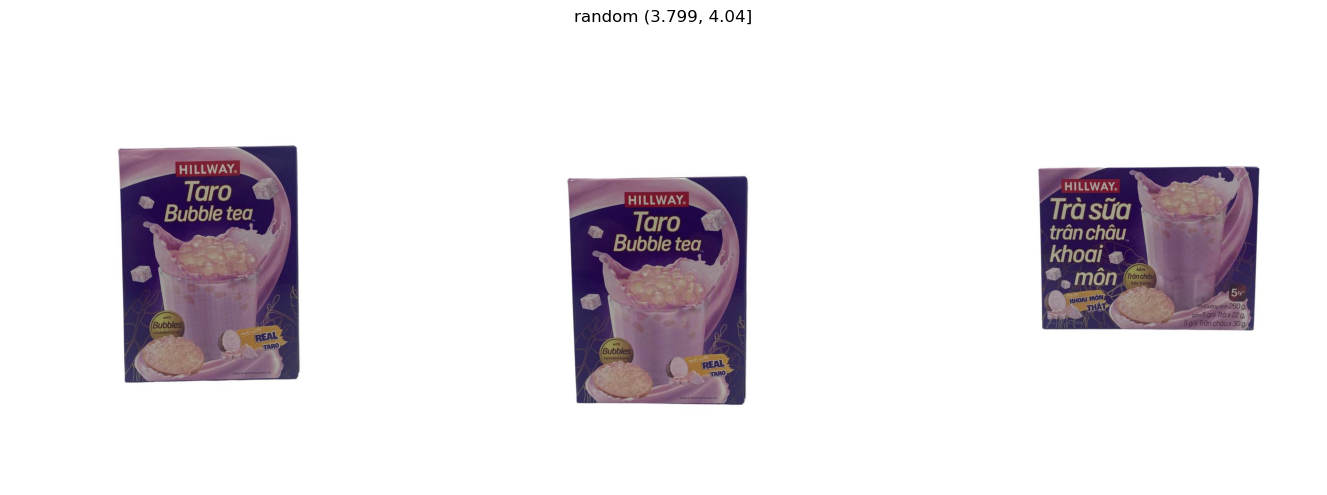

['C:/Users/senia/Desktop/wb sphere analysis/images/(4.04, 4.28]\\151514482_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.04, 4.28]\\151514482_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.04, 4.28]\\151514482_2.jpg']


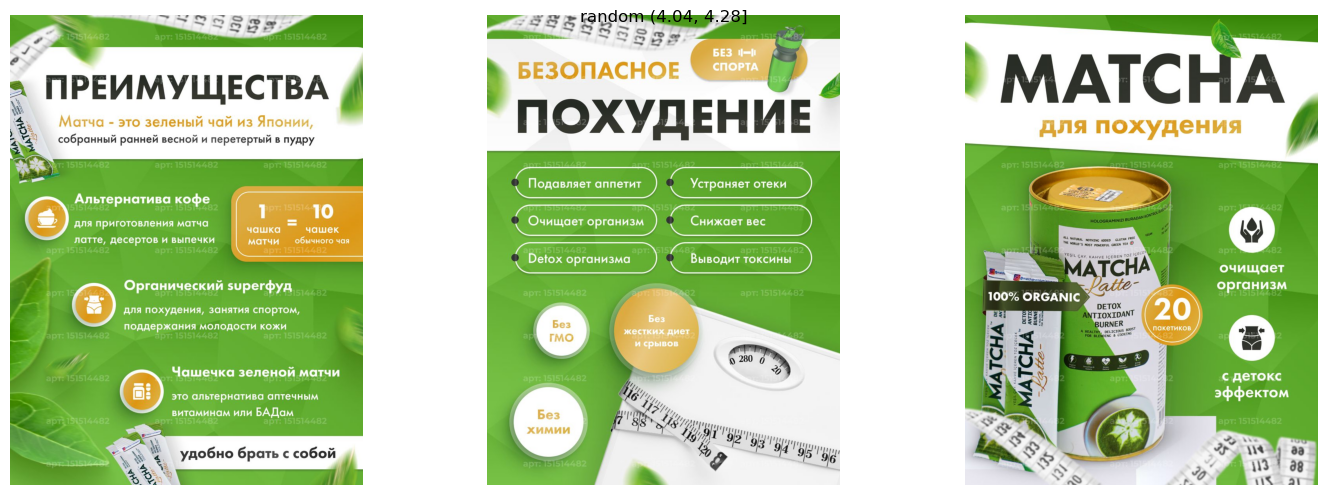

['C:/Users/senia/Desktop/wb sphere analysis/images/(4.28, 4.52]\\123252194_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.28, 4.52]\\123252194_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.28, 4.52]\\123252194_2.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.28, 4.52]\\12715874_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.28, 4.52]\\12715874_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.28, 4.52]\\12715874_2.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.28, 4.52]\\139139230_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.28, 4.52]\\139139230_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.28, 4.52]\\139139230_2.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.28, 4.52]\\140213245_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.28, 4.52]\\140213245_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.28, 4.52]\\140213245_2.jpg', 'C:/Users/senia/De

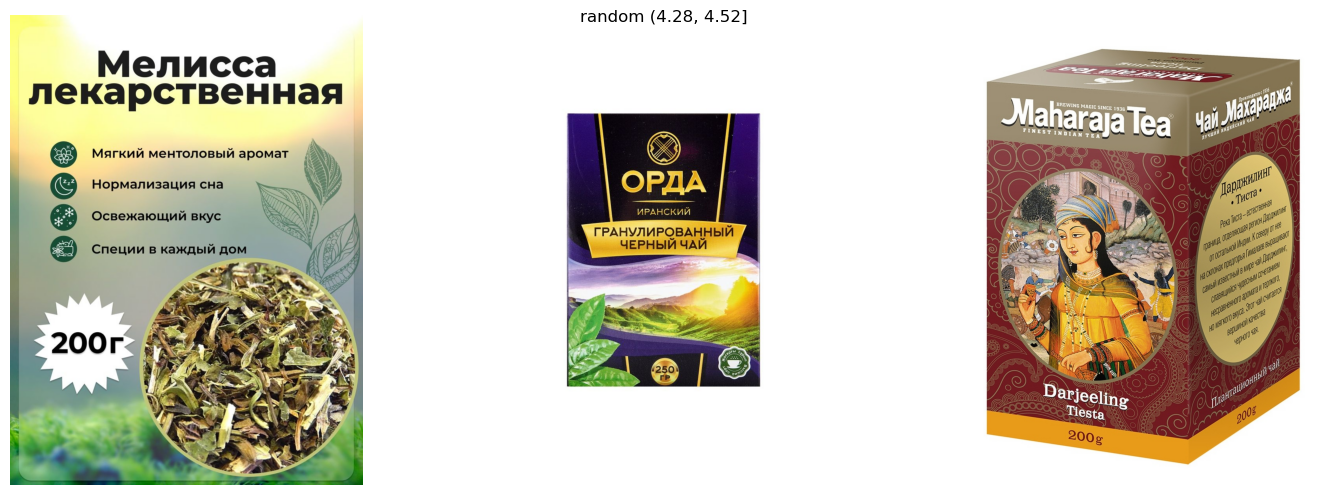

['C:/Users/senia/Desktop/wb sphere analysis/images/(4.52, 4.76]\\100016584_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.52, 4.76]\\100016584_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.52, 4.76]\\100016584_2.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.52, 4.76]\\10015303_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.52, 4.76]\\10015303_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.52, 4.76]\\10015303_2.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.52, 4.76]\\10015308_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.52, 4.76]\\10015308_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.52, 4.76]\\10015308_2.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.52, 4.76]\\10015310_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.52, 4.76]\\10015310_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.52, 4.76]\\10015310_2.jpg', 'C:/Users/senia/Desktop/

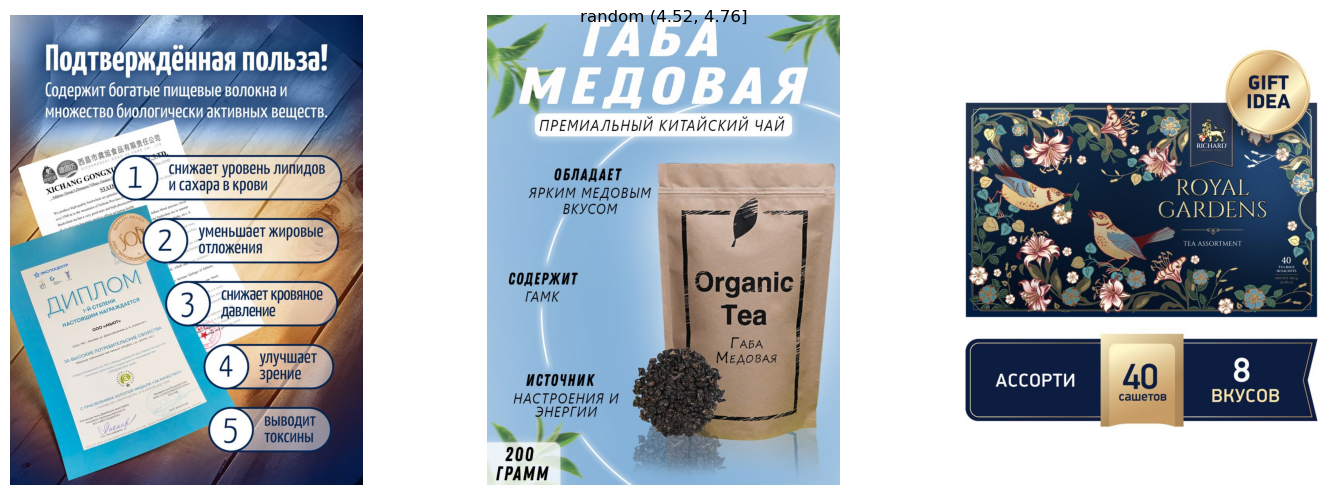

['C:/Users/senia/Desktop/wb sphere analysis/images/(4.76, 5.0]\\100088197_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.76, 5.0]\\100088197_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.76, 5.0]\\100088197_2.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.76, 5.0]\\100251138_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.76, 5.0]\\100251138_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.76, 5.0]\\100251138_2.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.76, 5.0]\\10045507_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.76, 5.0]\\10045507_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.76, 5.0]\\10045507_2.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.76, 5.0]\\10126010_0.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.76, 5.0]\\10126010_1.jpg', 'C:/Users/senia/Desktop/wb sphere analysis/images/(4.76, 5.0]\\10126010_2.jpg', 'C:/Users/senia/Desktop/wb sphere

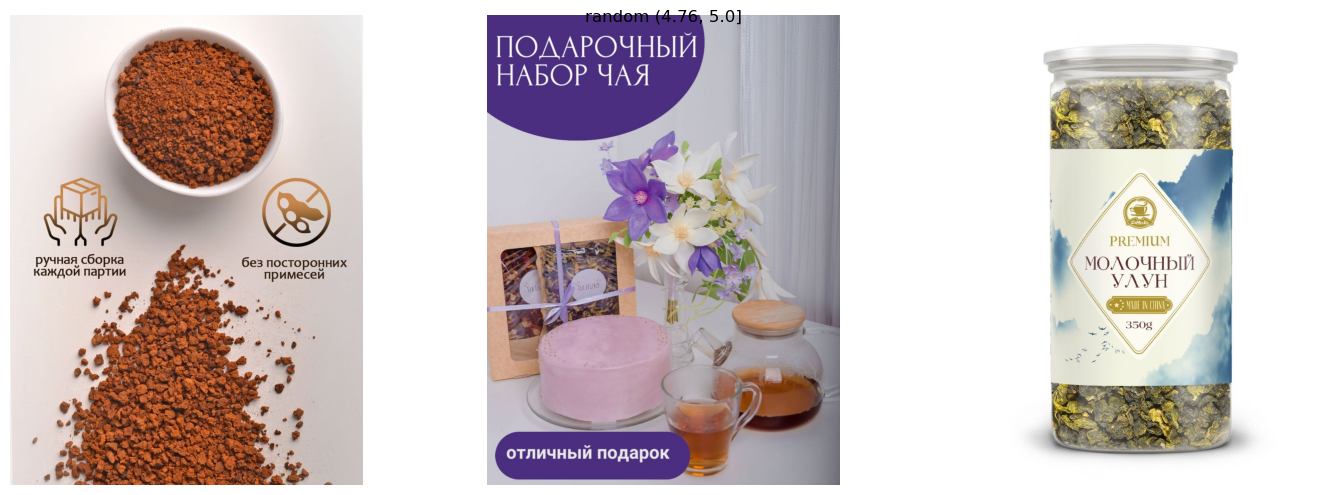

In [4]:
for folder in folds:
    folder_path = f'C:/Users/senia/Desktop/wb sphere analysis/images/{folder}' 

    image_files = [os.path.join(folder_path, file) for file in os.listdir(folder_path) if file.lower().endswith(('.jpg', '.png', '.jpeg'))]
    print(image_files)
    random_images = random.sample(image_files, 3)

    fig, axes = plt.subplots(1, 3, figsize=(15, 5)) 

    for i, image_path in enumerate(random_images):
        image = cv2.imread(image_path)
        if image is not None:
            image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            axes[i].imshow(image_rgb)
            axes[i].axis('off')

    plt.tight_layout()  
    plt.suptitle(f'random {folder}')
    plt.show()


In [5]:
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        transforms.CenterCrop(200), #will test impact of these two augmentations
        transforms.Pad(12),  #will test impact of these two augmentations
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

In [6]:
# initialize our dataset
data_folder = 'C:/Users/senia/Desktop/wb sphere analysis/images/'
dataset = ImageFolder(root=data_folder, transform=transform)

subset_size = 3000
dataset = Subset(dataset, range(subset_size))

# splitting percentages
train_pct = .8
test_pct = .2
val_pct = .1

# splitting into 80 train 20 test
global_train_size = int(len(dataset) * train_pct)
test_size = int(len(dataset) * test_pct)
global_train, test = random_split(dataset, [global_train_size, test_size])

# splitting train into 90 train 10 val
val_size = int(len(global_train) * val_pct) 
train_size = len(global_train) - val_size 
train, val = random_split(global_train, [train_size, val_size])

batch_size = 32 

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

In [7]:
def count_classes(loader):
    class_counts = {
        0: 0,
        1: 0,
        2: 0, 
        3: 0,
        4: 0
    } 

    for images, labels in loader:
        for label in labels.tolist():
            if label not in class_counts:
                class_counts[label] = 1
            else:
                class_counts[label] += 1

    sorted_counts = {k: v for k, v in sorted(class_counts.items())}
    return sorted_counts

def calculate_percentages(train_class_counts, val_class_counts, test_class_counts):
    percentages = {}
    for k, v in enumerate(train_class_counts):
        sm = train_class_counts[k] + val_class_counts[k] + test_class_counts[k]

        train_p = round(train_class_counts[k] * 100 / sm, 2)
        val_p = round(val_class_counts[k] * 100 / sm, 2)
        test_p = round(test_class_counts[k] * 100 / sm, 2)

        percentages[k] = {
            'train': train_p,
            'test': test_p,
            'val': val_p
        }

    return percentages

# Check class counts and percentages for train_loader, val_loader, and test_loader
train_class_counts = count_classes(train_loader)
val_class_counts = count_classes(val_loader)
test_class_counts = count_classes(test_loader)

print('Class counts in train_loader:', train_class_counts)
print('Class counts in val_loader:', val_class_counts)
print('Class counts in test_loader:', test_class_counts)

percentages = calculate_percentages(train_class_counts, val_class_counts, test_class_counts)
print('Each class percentage:', percentages)


Class counts in train_loader: {0: 1, 1: 3, 2: 157, 3: 1751, 4: 248}
Class counts in val_loader: {0: 0, 1: 0, 2: 11, 3: 190, 4: 39}
Class counts in test_loader: {0: 2, 1: 0, 2: 38, 3: 471, 4: 89}
Each class percentage: {0: {'train': 33.33, 'test': 66.67, 'val': 0.0}, 1: {'train': 100.0, 'test': 0.0, 'val': 0.0}, 2: {'train': 76.21, 'test': 18.45, 'val': 5.34}, 3: {'train': 72.6, 'test': 19.53, 'val': 7.88}, 4: {'train': 65.96, 'test': 23.67, 'val': 10.37}}


In [8]:
# use GPU 
device = 'cuda'

In [9]:
# create function that plots training cycle
def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title(title)
    plt.plot(train_history, label='train', zorder=1)

    points = np.array(val_history)
    steps = list(
        range(0, len(train_history) + 1, int(len(train_history) / len(val_history)))
    )[1:]

    plt.scatter(
        steps, val_history, marker='+', s=180, c='orange', label='val', zorder=2
    )
    plt.xlabel('train steps')

    plt.legend(loc='best')
    plt.grid()

    plt.show()

In [10]:
# training function creation
def train_nn(model, criterion, optimizer, train_dataloader, val_dataloader, n_epochs=5, verbose=False, scheduler_gamma=1):
    train_loss_log, train_acc_log, val_loss_log, val_acc_log = [], [], [], []
    train_f1_log, train_f1_glob_log, val_f1_log, val_f1_glob_log= [], [], [], []

    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=scheduler_gamma)

    for epoch in range(n_epochs):
        # training
        
        train_epoch_loss, train_epoch_true_hits  = torch.empty(0), torch.empty(0)
        train_epoch_f1, train_epoch_f1_glob = [], []
        all_train_preds, all_train_labels = [], []

        model.train()
        for imgs, labels in tqdm(
            train_dataloader, desc=f"Training, epoch {epoch}, lr: {optimizer.param_groups[0]['lr']}", leave=False
        ):
            imgs, labels = imgs.to(device), labels.to(device)

            y_pred = model(imgs)
            loss = criterion(y_pred, labels)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            # log loss for the current epoch and the whole training history
            train_epoch_loss = torch.cat(
                (train_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
            )
            train_loss_log.append(loss.cpu().data / labels.cpu().size(0))

            # log accuracy for the current epoch and the whole training history
            pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
            train_epoch_true_hits = torch.cat(
                (
                    train_epoch_true_hits,
                    (pred_classes == labels.cpu()).sum().unsqueeze(0),
                )
            )
            train_acc_log.append(
                (pred_classes == labels.cpu()).sum() / labels.cpu().shape[0]
            )

            train_epoch_f1.append(f1_score(labels.cpu(), pred_classes, average='weighted'))
            train_f1_log.append(torch.tensor(train_epoch_f1).mean().item())

            all_train_preds.extend(pred_classes.cpu().tolist())
            all_train_labels.extend(labels.cpu().tolist())

            train_epoch_f1_glob.append(f1_score(all_train_labels, all_train_preds, average='weighted'))
            train_f1_glob_log.append(torch.tensor(train_epoch_f1_glob).mean().item())

            
        scheduler.step()

        # validation
        val_epoch_loss, val_epoch_true_hits = torch.empty(0), torch.empty(0)
        val_epoch_f1, val_epoch_f1_glob = [], []
        all_val_preds, all_val_labels = [], []

        model.eval()
        with torch.no_grad():
            for imgs, labels in tqdm(
                val_dataloader, desc=f"Validating, epoch {epoch}", leave=False
            ):
                imgs, labels = imgs.to(device), labels.to(device)

                y_pred = model(imgs)
                loss = criterion(y_pred, labels)
                val_epoch_loss = torch.cat(
                    (val_epoch_loss, loss.cpu().unsqueeze(0) / labels.cpu().size(0))
                )

                pred_classes = torch.argmax(y_pred.cpu(), dim=-1)
                val_epoch_true_hits = torch.cat(
                    (
                        val_epoch_true_hits,
                        (pred_classes == labels.cpu()).sum().unsqueeze(0),
                    )
                )

                val_epoch_f1.append(f1_score(labels.cpu(), pred_classes, average='weighted'))
                val_f1_log.append(torch.tensor(val_epoch_f1).mean().item())

                
                all_val_preds.extend(pred_classes.cpu().tolist())
                all_val_labels.extend(labels.cpu().tolist())

                val_epoch_f1_glob.append(f1_score(all_val_labels, all_val_preds, average='weighted'))
                val_f1_glob_log.append(torch.tensor(val_epoch_f1_glob).mean().item())

        val_loss_log.append(val_epoch_loss.mean())
        val_acc_log.append(
            val_epoch_true_hits.sum()
            / val_epoch_true_hits.size(0)
            / val_dataloader.batch_size
        ) 
        clear_output()
        fnl_loss_train = train_epoch_loss.mean().item()
        fnl_loss_val = val_epoch_loss.mean().item()
        fnl_f1_train = torch.tensor(train_epoch_f1).mean().item()
        fnl_f1_val = torch.tensor(val_epoch_f1).mean().item()
        fnl_f1_glob_train = torch.tensor(train_epoch_f1_glob).mean().item()
        fnl_f1_glob_val = torch.tensor(val_epoch_f1_glob).mean().item()
        fnl_acc_train = (
                    train_epoch_true_hits.sum()
                    / train_epoch_true_hits.size(0)
                    / train_dataloader.batch_size
                ).item()
        fnl_acc_val =                 (
                    val_epoch_true_hits.sum()
                    / val_epoch_true_hits.size(0)
                    / val_dataloader.batch_size
                ).item()
        

        if verbose:
            plot_history(train_loss_log, val_loss_log, "loss")
            plot_history(train_acc_log, val_acc_log, "accuracy")
            plot_history(train_f1_log, val_f1_log, "f1")
            plot_history(train_f1_glob_log, val_f1_glob_log, "f1 global")


            print("Train loss:", fnl_loss_train)
            print("Train acc:", fnl_acc_train)
            print("Train f1:", fnl_f1_train)
            print("Train f1 global:", fnl_f1_glob_train)
            print("Val loss:", fnl_loss_val)
            print("Val acc:", fnl_acc_val)
            print("Val f1:", fnl_f1_val)
            print("Val f1 global:", fnl_f1_glob_val)
    
    return fnl_loss_train, fnl_acc_train, fnl_f1_train, fnl_f1_glob_train, fnl_loss_val, fnl_acc_val, fnl_f1_val, fnl_f1_glob_val

In [11]:
#initialize our transformations
transform = transforms.Compose(
    [
        transforms.ToTensor(),
        transforms.Resize((224,224)),
        # transforms.CenterCrop(200), #will test impact of these two augmentations
        # transforms.Pad(12),  #will test impact of these two augmentations
        transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))
    ]
)

def preprocess(
        data_path, 
        transform, 
        train_size=.7, 
        test_size=.2, 
        val_size=.1, 
        batch_size=16,
        seed = 42
        ):
        
    seed = seed
    torch.manual_seed(seed)
    random.seed(seed)
    
    # initialize our dataset
    data_folder = data_path
    dataset = ImageFolder(root=data_folder, transform=transform)

    # splitting percentages
    train_pct = train_size + val_size
    val_pct = val_size

    # splitting into 80 train 20 test
    global_train_size = int(len(dataset) * train_pct)
    test_size = len(dataset) - global_train_size
    global_train, test = random_split(dataset, [global_train_size, test_size])

    # splitting train into 90 train 10 val
    val_size = int(len(global_train) * val_pct) 
    train_size = len(global_train) - val_size 
    train, val = random_split(global_train, [train_size, val_size])

    batch_size = batch_size 

    train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val, batch_size=batch_size, shuffle=True)

    return train_loader, test_loader, val_loader

def train(
        train_loader, 
        val_loader, 
        optimizer=optim.SGD,
        loss=nn.CrossEntropyLoss,
        model=models.resnet50(pretrained=True),
        learning_rate=.001, 
        n_epochs=5,
        scheduler_gamma=1,
        verbose=False
        ):

    md = model.to(device)
    criterion = loss()
    opt = optimizer(md.parameters(), lr=learning_rate)
    train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob = train_nn(
        md, 
        criterion, 
        opt, 
        train_loader, 
        val_loader, 
        verbose=verbose, 
        n_epochs=n_epochs, 
        scheduler_gamma=scheduler_gamma)
    
    return train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob

In [12]:
train_load, test_load, val_load = preprocess('C:/Users/senia/Desktop/wb sphere analysis/images/', transform, batch_size=32)

In [13]:
lr = [.1, .0001, .005, .0005]

results = {}
for l in lr:
    train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob = train(
        train_load,
        val_load,
        learning_rate=l
    )
    results[l] = (train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob)
results

{0.1: (0.015801673755049706,
  0.7920305728912354,
  0.7689147786463554,
  0.7733444017054395,
  0.01792137697339058,
  0.7596153616905212,
  0.7500499110879855,
  0.7362920504924243),
 0.0001: (0.011436651460826397,
  0.8617631196975708,
  0.8478682359360958,
  0.8483553450227773,
  0.0173037126660347,
  0.7740384340286255,
  0.7677995843506822,
  0.7706418363193218),
 0.005: (0.003945268224924803,
  0.9587882161140442,
  0.9584212469882438,
  0.9547709165966697,
  0.020901737734675407,
  0.786057710647583,
  0.792304338265873,
  0.7908694565502622),
 0.0005: (0.00237088231369853,
  0.9777565598487854,
  0.9777584189857603,
  0.9786171789058035,
  0.022113433107733727,
  0.786057710647583,
  0.7966241639373812,
  0.8071082271457257)}

In [14]:
lr = [0.0001]

results = {}
for l in lr:
    train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob = train(
        train_load,
        val_load,
        learning_rate=l,
        model=models.resnet101(pretrained=True),
        optimizer=optim.Adam,
        n_epochs=5, 
        verbose=False,
        scheduler_gamma=1
    )
    results[l] = (train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob)
results

{0.0001: (0.003392767161130905,
  0.9593340754508972,
  0.9591785512662273,
  0.9657117718881594,
  0.02547193504869938,
  0.8100961446762085,
  0.8073920753282805,
  0.8098856270901836)}

In [15]:
class ResNetWithDropout(nn.Module):
    def __init__(self, n_classes=6, dropout_prob=0.5):
        super(ResNetWithDropout, self).__init__()
        resnet = models.resnet101(pretrained=True)
        
        # remove the original fully connected layer
        modules = list(resnet.children())[:-1]
        self.features = nn.Sequential(*modules)
        
        # add a new fully connected layer with dropout
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_prob),
            nn.Linear(resnet.fc.in_features, n_classes)
        )
        
    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

In [16]:
lr = [0.00007]
model = ResNetWithDropout()

results = {}
for l in lr:
    train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob = train(
        train_load,
        val_load,
        learning_rate=l,
        model=model,
        optimizer=optim.Adam,
        n_epochs=2, 
        verbose=False,
        scheduler_gamma=1
    )
    results[l] = (train_loss, train_acc, train_f1, train_f1_glob, val_loss, val_acc, val_f1, val_f1_glob)
results

{7e-05: (0.009615538641810417,
  0.8842794895172119,
  0.8781693663533523,
  0.8852106385582669,
  0.01847757212817669,
  0.7896634340286255,
  0.7928719108843948,
  0.7965692142628347)}